In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans


In [2]:
data = pd.read_csv("Online Retail.csv", encoding = "ISO-8859-1")
print(data.info())
data.head() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37005 entries, 0 to 37004
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    37005 non-null  object 
 1   StockCode    37004 non-null  object 
 2   Description  36887 non-null  object 
 3   Quantity     37004 non-null  float64
 4   InvoiceDate  37004 non-null  object 
 5   UnitPrice    37004 non-null  float64
 6   CustomerID   24364 non-null  float64
 7   Country      37004 non-null  object 
dtypes: float64(3), object(5)
memory usage: 2.3+ MB
None


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
print("Shape before dropping duplicates", data.shape)
data = data.drop_duplicates()
print("Shape after dropping duplicates", data.shape)

Shape before dropping duplicates (37005, 8)
Shape after dropping duplicates (36534, 8)


In [4]:
print("Data Shape", data.shape)
for col in ["InvoiceNo","StockCode","InvoiceDate","CustomerID", "Country"]:
    print("Unique Values for ", col, " - ", data[col].nunique())

Data Shape (36534, 8)
Unique Values for  InvoiceNo  -  1772
Unique Values for  StockCode  -  2743
Unique Values for  InvoiceDate  -  1537
Unique Values for  CustomerID  -  897
Unique Values for  Country  -  23


In [5]:
print(np.sum(data.isnull()), "\n")
print("Percentage of customers missing: ", round(data['CustomerID'].isnull().sum() * 100 / len(data),2),"%" )

InvoiceNo          0
StockCode          1
Description      118
Quantity           1
InvoiceDate        1
UnitPrice          1
CustomerID     12639
Country            1
dtype: int64 

Percentage of customers missing:  34.6 %


In [6]:

null_id_invoices = data[data.CustomerID.isnull()]["InvoiceNo"].drop_duplicates().tolist()
print("Invoices count with Null Customer ID", len(null_id_invoices))
### Check if InvoiceNo in Null CustomerID dataframe exist in Non-Null Customer ID Dataframe
data[~data.CustomerID.isnull()][data.InvoiceNo.isin(null_id_invoices)]

Invoices count with Null Customer ID 247


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [7]:
data.groupby(['InvoiceNo'])['CustomerID'] \
                             .nunique() \
                             .reset_index(name='nunique') \
                             .sort_values(['nunique'], ascending=False) \
                             .head(5)

,InvoiceNo,nunique
886,538076,1
1168,538744,1
1179,538807,1
1178,538801,1
1177,538800,1


In [8]:
data['NewID'] = data['CustomerID']
data.loc[data['CustomerID'].isnull(), ['NewID']] = data['InvoiceNo']

#Remove all non digits from column NewID (Since Invoice can contains "C" referring to cancellations)
data['NewID'] = data['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
data['NewID'] = pd.to_numeric(data['NewID'])

### Check if presnt customerIds and New Ids have any common values since it would create alter actual Customer Insights
customer = data['CustomerID'].nunique()
null_invoices = data[data.CustomerID.isnull()]['InvoiceNo'].nunique()
new_ids = data['NewID'].nunique()
print("Number of Customers:", customer)
print("Number of Orders where CustomerID in Null:", null_invoices)
print("Number of Customers + Number of Orders where CustomerID in Null:", customer + null_invoices)
print("Number of New ID's:", new_ids)

Number of Customers: 897
Number of Orders where CustomerID in Null: 247
Number of Customers + Number of Orders where CustomerID in Null: 1144
Number of New ID's: 1144


In [9]:
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])
print("Minimum Invoice Date", min(data["InvoiceDate"]))
print("Maximum Invoice Date", max(data["InvoiceDate"]))

Minimum Invoice Date 2010-01-12 08:26:00
Maximum Invoice Date 2010-12-17 17:08:00


In [10]:
data["cancellations"] = np.where(data["InvoiceNo"].str.startswith('C'), 1,0)
total_data = data["InvoiceNo"].shape[0]
cancelled_data = data[data.cancellations == 1].shape[0]
print("Number of cancelled products data", cancelled_data, cancelled_data*100/total_data, "\n")

print(data[data.cancellations == 1]["Quantity"].describe())

#### Removing cancellations since they have negative quantities and makes only ~2% of data
data = data[data.cancellations == 0]

Number of cancelled products data 587 1.6067225050637761 

count     587.000000
mean      -25.376491
std       387.288134
min     -9360.000000
25%        -6.000000
50%        -2.000000
75%        -1.000000
max        -1.000000
Name: Quantity, dtype: float64


In [11]:
data[data.UnitPrice<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations


In [12]:
data = data[data.UnitPrice >= 0]

In [13]:
print("% of data with Price = 0: ", round(len(data[data.UnitPrice == 0]) * 100 / len(data),2),"%" )
print("Count of unique Customer ID values ", data[data.UnitPrice == 0].CustomerID.nunique(), "\n")
data[data.UnitPrice == 0][~data.CustomerID.isnull()].head()

% of data with Price = 0:  0.54 %
Count of unique Customer ID values  2 



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,NewID,cancellations
9302,537197,22841,ROUND CAKE TIN VINTAGE GREEN,1.0,2010-05-12 14:02:00,0.0,12647.0,Germany,126470,0
33576,539263,22580,ADVENT CALENDAR GINGHAM SACK,4.0,2010-12-16 14:36:00,0.0,16560.0,United Kingdom,165600,0


In [14]:
### Dropping Cases with UnitPrice = 0
data_filtered = data[data.UnitPrice >0]
data_filtered["UnitPrice"].describe()

count    35753.000000
mean         4.732838
std         74.463053
min          0.070000
25%          1.450000
50%          2.510000
75%          4.250000
max      13541.330000
Name: UnitPrice, dtype: float64

In [15]:
print("Minimum Quantity", min(data_filtered["Quantity"]))
print("Maximum Quantity", max(data_filtered["Quantity"]))
data_filtered["Quantity"].describe()

Minimum Quantity 1.0
Maximum Quantity 2880.0


count    35753.000000
mean         8.782368
std         37.689951
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       2880.000000
Name: Quantity, dtype: float64

In [16]:
### Adding Monetary information by calculating total value of transaction by multiplying unit price and quantity of the product
data_filtered["Total_sales"] = data_filtered["UnitPrice"]*data_filtered["Quantity"]

### Creating Country Level grouping to find Unique Customer count and %
country_customer_df = data_filtered.groupby("Country")["CustomerID"].nunique().reset_index().rename(columns = \
                                                                                           {"CustomerID":"count_CustomerID"})
country_customer_df["customer_%"] = round(country_customer_df["count_CustomerID"]*\
                                          100/country_customer_df["count_CustomerID"].sum(),2)

### Creating Country Level grouping to find total revenue and %
country_df = data_filtered.groupby("Country")["Total_sales"].sum().reset_index()
country_df["Total_sales%"] = round(country_df["Total_sales"]*100/country_df["Total_sales"].sum(),2)

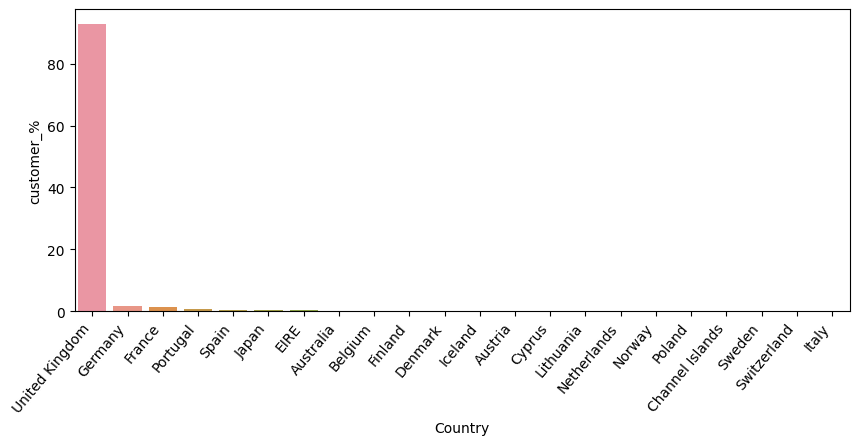

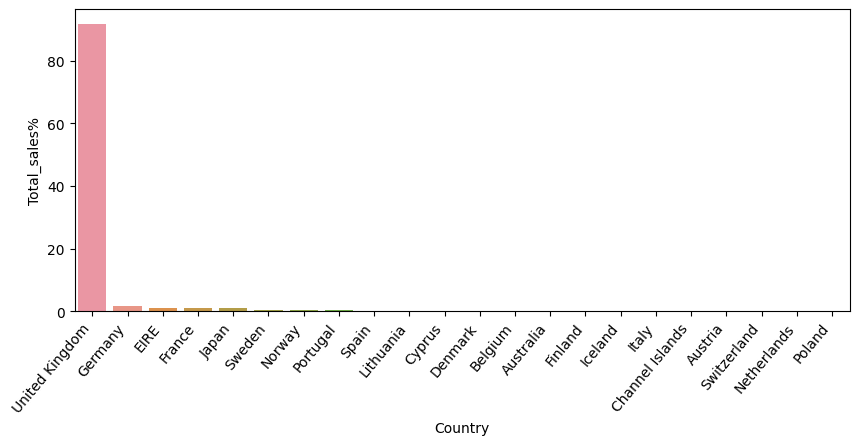

In [17]:
country_customer_df = country_customer_df.sort_values(by = "customer_%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_customer_df["Country"], y=country_customer_df['customer_%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

country_df = country_df.sort_values(by = "Total_sales%", ascending = False)
fig, ax = plt.subplots(figsize=(10,4),dpi=100)
ax=sns.barplot(x=country_df["Country"], y=country_df['Total_sales%'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

In [18]:
uk_df = data_filtered[data_filtered.Country == "United Kingdom"]
uk_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 33925 entries, 0 to 37003
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   InvoiceNo      33925 non-null  object        
 1   StockCode      33925 non-null  object        
 2   Description    33925 non-null  object        
 3   Quantity       33925 non-null  float64       
 4   InvoiceDate    33925 non-null  datetime64[ns]
 5   UnitPrice      33925 non-null  float64       
 6   CustomerID     21554 non-null  float64       
 7   Country        33925 non-null  object        
 8   NewID          33925 non-null  int64         
 9   cancellations  33925 non-null  int64         
 10  Total_sales    33925 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(4)
memory usage: 3.1+ MB


In [19]:
uk_product = uk_df.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', \
                                                                                                      ascending=False)
uk_product.head(5)

,StockCode,Description,Quantity
2024,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4324.0
2373,85123A,WHITE HANGING HEART T-LIGHT HOLDER,3408.0
1576,22834,HAND WARMER BABUSHKA DESIGN,2945.0
1440,22693,GROW A FLYTRAP OR SUNFLOWER IN TIN,2593.0
1249,22492,MINI PAINT SET VINTAGE,2349.0


In [20]:
#Find the unique number of InvoiceNo  per customer for analysis of United Kingdom 
groupby_customers = pd.DataFrame(uk_df.groupby('NewID')['InvoiceNo'].nunique())
groupby_customers.describe()

,InvoiceNo
count,875.000000
mean,1.458286
std,1.729151
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,34.000000


In [21]:
#Find the unique number of products per Order
groupby_invoice = pd.DataFrame(uk_df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of products per Order']
groupby_invoice.describe()

,Number of products per Order
count,1276.000000
mean,26.275078
std,66.426680
min,1.000000
25%,5.000000
50%,13.000000
75%,25.250000
max,674.000000


In [22]:
analysis_date = uk_df["InvoiceDate"].max() + pd.DateOffset(1)
print("RFM Analysis Date :", analysis_date)

start_date = analysis_date - pd.DateOffset(days = 365)
print("Start Date when taking 1 year data for analysis :", start_date)

RFM Analysis Date : 2010-12-18 17:08:00
Start Date when taking 1 year data for analysis : 2009-12-18 17:08:00


In [23]:
### Drop Nulls in CUstomerID
uk_df = uk_df[~uk_df.CustomerID.isnull()]

# Aggregate data on a customer level to get RFM values
data_rfm = uk_df[uk_df.InvoiceDate >= start_date].groupby(['NewID'],as_index=False).agg({'InvoiceDate': lambda x: (analysis_date - x.max()).days,
'InvoiceNo': 'count','Total_sales': 'sum'}).rename(columns = {'InvoiceDate': 'Recency', \
                                            'InvoiceNo': 'Frequency','Total_sales': 'Monetary'})
data_rfm.head()

,NewID,Recency,Frequency,Monetary
0,127470,5,15,706.27
1,127480,1,598,3955.09
2,128260,97,9,155.00
3,128290,4,5,85.75
4,128380,340,59,390.79


In [24]:
### Getting individual RFM scores by using quantiles for each of the columns
data_rfm['R_score'] = pd.qcut(data_rfm['Recency'], 4, labels=False)
data_rfm['F_score'] = pd.qcut(data_rfm['Frequency'], 4, labels=False)
data_rfm['M_score'] = pd.qcut(data_rfm['Monetary'], 4, labels=False)

### Since a low Recency score means recent transactions and good customer, changine quantile values 
### so that low values rank highest ans vice versa
data_rfm['R_score'] = 3 - data_rfm['R_score']

data_rfm['RFM'] = data_rfm.R_score.map(str) \
                            + data_rfm.F_score.map(str) \
                            + data_rfm.M_score.map(str)

### Calculating Final RFM score
data_rfm["RFM_Score"] = data_rfm['R_score'] + data_rfm['F_score'] + data_rfm['M_score']
data_rfm.head(10)

,NewID,Recency,Frequency,Monetary,R_score,F_score,M_score,RFM,RFM_Score
0,127470,5,15,706.27,2,1,3,213,6
1,127480,1,598,3955.09,3,3,3,333,9
2,128260,97,9,155.00,2,0,0,200,2
3,128290,4,5,85.75,3,0,0,300,3
4,128380,340,59,390.79,0,3,2,032,5
5,128390,159,22,402.61,1,2,2,122,5
6,128410,220,47,505.99,0,3,2,032,5
7,128550,309,3,38.10,0,0,0,000,0
8,128670,4,54,362.79,3,3,2,332,8
9,128680,340,12,203.30,0,1,1,011,2


In [25]:
data_rfm.groupby("RFM_Score")[['Recency','Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
RFM_Score,,,
0,305.812500,4.656250,107.209375
1,217.339623,6.622642,166.184340
2,194.127907,12.290698,193.197209
3,141.247619,11.828571,272.027524
4,137.980769,22.048077,335.888365
5,85.268041,24.412371,389.807320
6,85.190909,36.209091,944.891727
7,29.060241,31.987952,584.785904
8,14.698413,54.920635,1200.022063


                ----------------- Distribution Plots for R,F,M -------------------------------


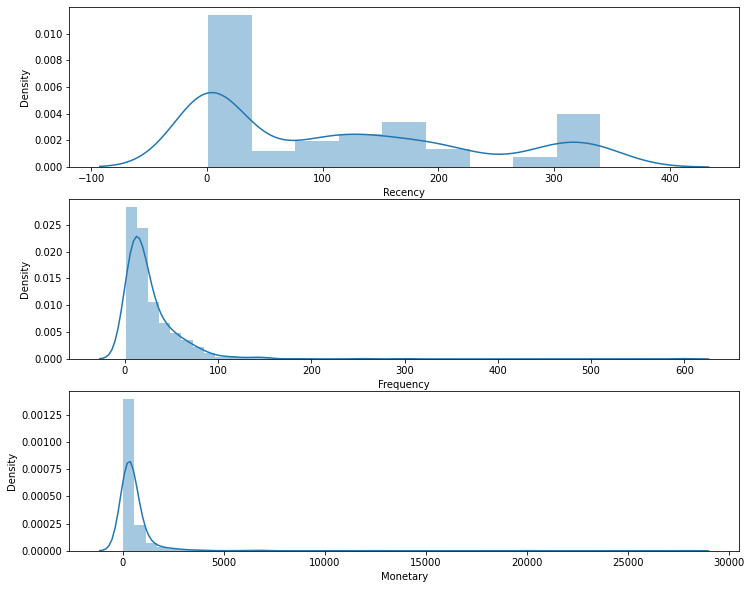

In [26]:
print("                ----------------- Distribution Plots for R,F,M -------------------------------")

# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))
# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data_rfm['Recency'])
# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data_rfm['Frequency'])
# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data_rfm['Monetary'])

                ----------------- Log Transformation Plots for R,F,M -------------------------------


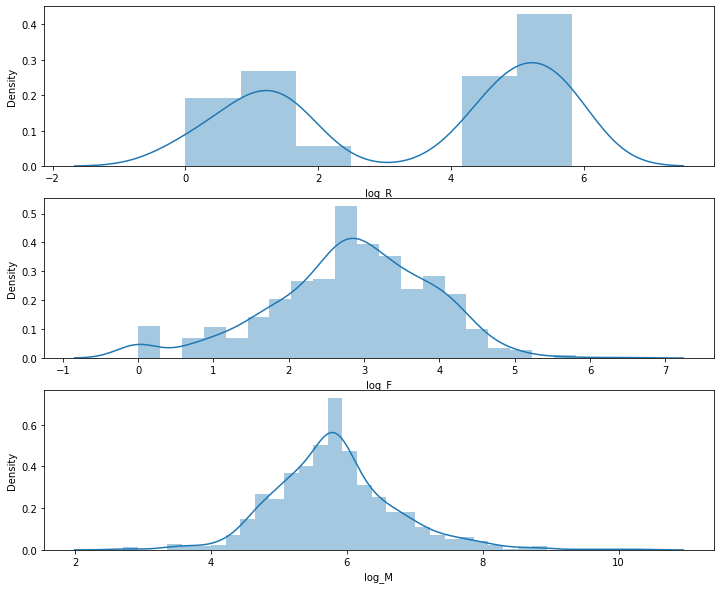

In [27]:
# Taking Log of columns
data_rfm["log_R"] = np.log(data_rfm.Recency)
data_rfm["log_F"] = np.log(data_rfm.Frequency)
data_rfm["log_M"] = np.log(data_rfm.Monetary)

# Checking the distribution of Recency, Frequency and Monetary variables after log transformation
print("                ----------------- Log Transformation Plots for R,F,M -------------------------------")
plt.figure(figsize=(12,10))
plt.subplot(3, 1, 1)
sns.distplot(data_rfm['log_R'])
plt.subplot(3, 1, 2)
sns.distplot(data_rfm['log_F'])
plt.subplot(3, 1, 3)
sns.distplot(data_rfm['log_M'])

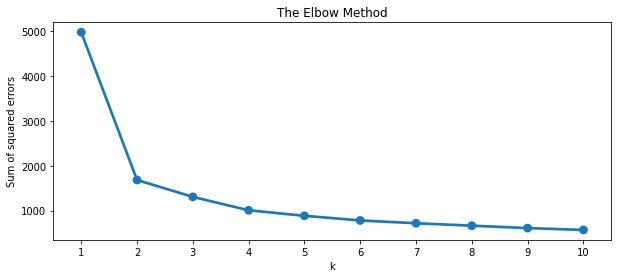

In [28]:
### Features Used in training K Means - Log Transformed Recency, Frequency and Monetary values
data_norm = data_rfm[["log_R", "log_F", "log_M"]]

sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_
    
# Plotting the elbow plot
plt.figure(figsize=(10,4))
plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5958500383294469
For n_clusters = 3 The average silhouette_score is : 0.4514261120605676
For n_clusters = 4 The average silhouette_score is : 0.349352238882941
For n_clusters = 5 The average silhouette_score is : 0.303402719631009
For n_clusters = 6 The average silhouette_score is : 0.2929091709248332


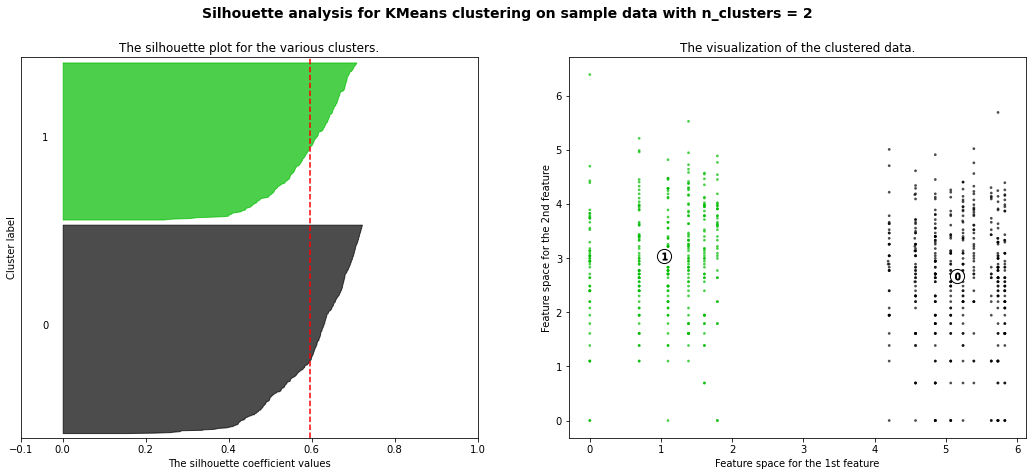

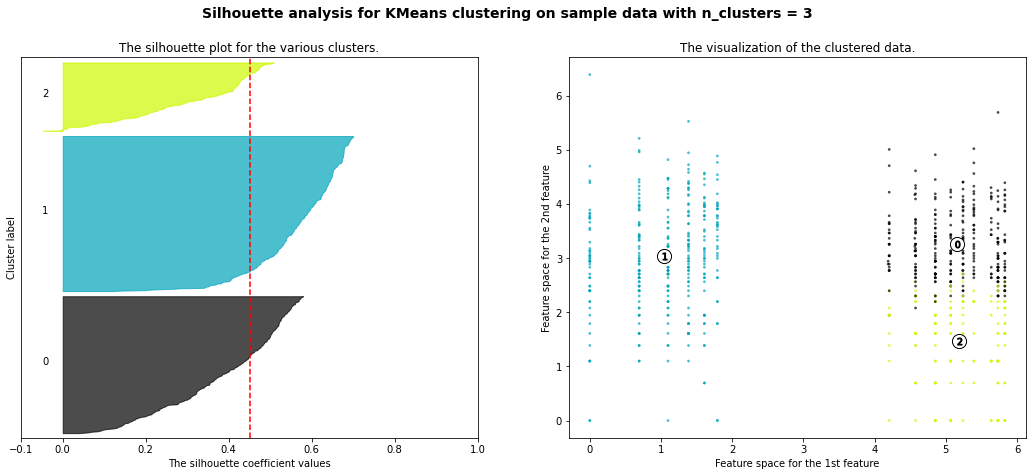

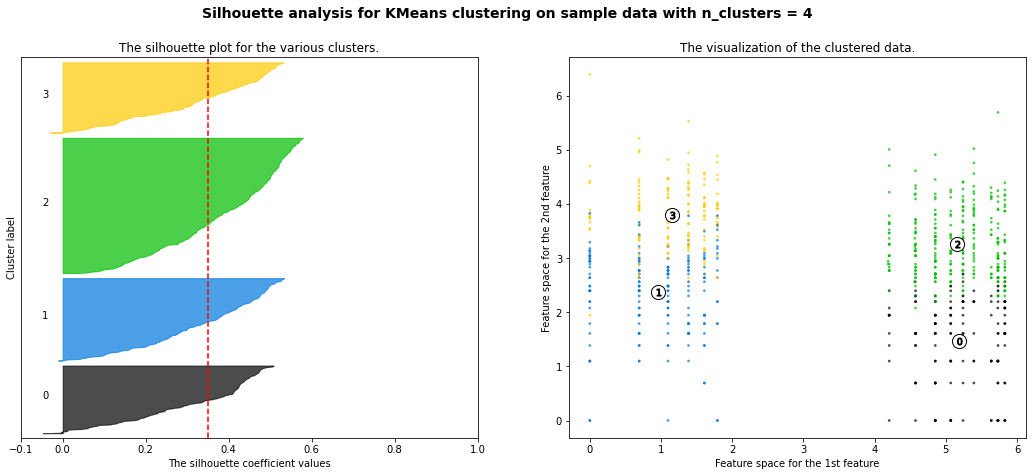

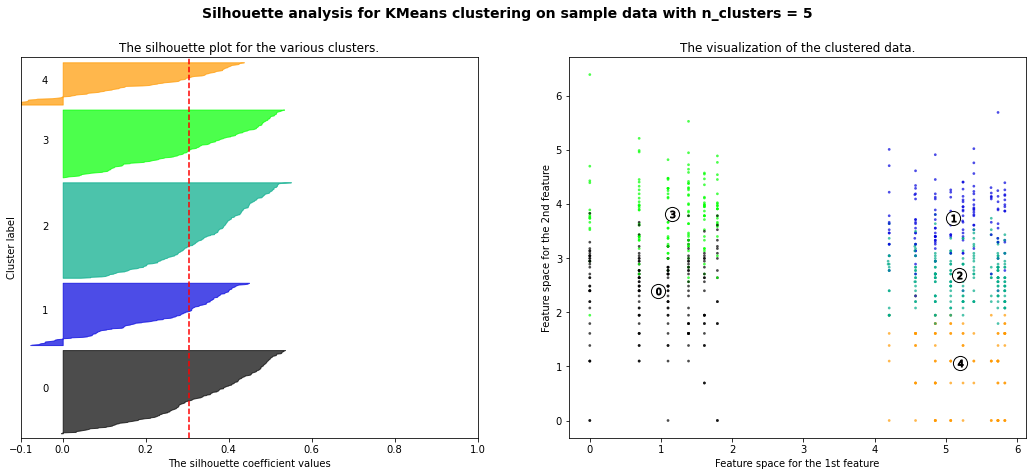

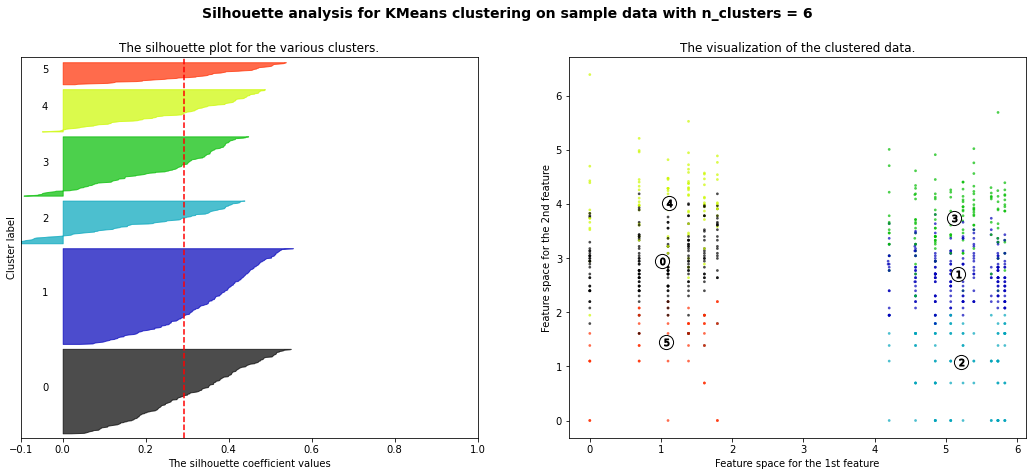

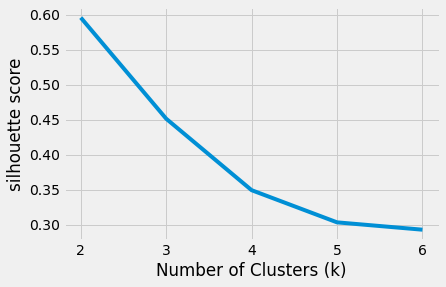

In [35]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_norm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(data_norm)

   # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_norm, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_norm, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(data_norm.iloc[:, 0], data_norm.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


style.use("fivethirtyeight")
plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

In [29]:
n_clusters = 3
kmeans = KMeans(n_clusters = n_clusters, random_state=1)
kmeans.fit(data_norm)
data_rfm["cluster"] = kmeans.predict(data_norm)

In [30]:
data_rfm.groupby(["cluster"])[['Recency','Frequency', 'Monetary']].mean()


,Recency,Frequency,Monetary
cluster,,,
0,201.682432,5.574324,238.820743
1,3.284431,33.248503,748.733862
2,194.342373,32.623729,587.504949


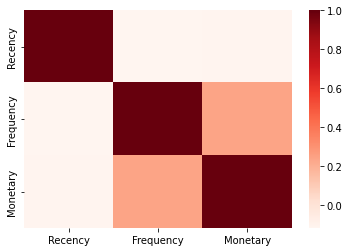

In [31]:
sns.heatmap(data_rfm[['Recency','Frequency', 'Monetary']].corr(),cmap="Reds")



Text(0, 0.5, 'Monetary')

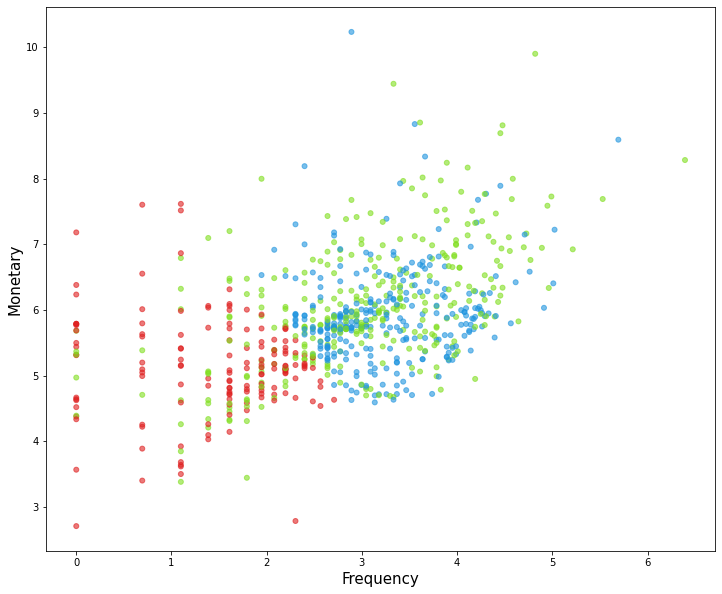

In [32]:
# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

## add to dataframe
data_rfm['cen_x'] = data_rfm.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
data_rfm['cen_y'] = data_rfm.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})

# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
data_rfm['c'] = data_rfm.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

# Plot clusters
plt.figure(figsize=(12,10))
plt.scatter(data_rfm.log_F, data_rfm.log_M, c=data_rfm.c, alpha = 0.6, s=25)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)